In [1]:
import torch
print(torch.cuda.is_available())

True


# **PROCESS**

In [2]:
import os
import shutil

src_folder = '/content/drive/MyDrive/archive'
dst_folder = '/content/datasets'
os.makedirs(dst_folder, exist_ok=True)
print("Thư mục đích đã sẵn sàng:", dst_folder)



Thư mục đích đã sẵn sàng: /content/datasets


In [3]:
train_ratio = 0.8 # 80% dữ liệu để huấn luyện
valid_ratio = 0.1 # 10% dữ liệu để validation
img_size = 640 # Resize ảnh về 640x640

In [4]:
# Cấu trúc thư mục
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(dst_folder, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dst_folder, split, 'labels'), exist_ok=True)

# Load class names
with open(os.path.join(src_folder, 'classes_vie.txt'), 'r', encoding='utf-8') as f:
    classes = [line.strip() for line in f.readlines()]

In [5]:
import random

all_images = [os.path.join(src_folder, 'images', f) for f in os.listdir(os.path.join(src_folder, 'images')) if f.endswith('.jpg')]
random.shuffle(all_images)

In [6]:
# Split dataset
train_size = int(len(all_images) * train_ratio)
valid_size = int(len(all_images) * valid_ratio)

train_images = all_images[:train_size]
valid_images = all_images[train_size:train_size+valid_size]
test_images = all_images[train_size+valid_size:]


Tăng cường dữ liệu

In [7]:
# Comprehensive augmentation pipeline
import albumentations as A

augmentations = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.Affine(shear=5, p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.2),
    A.GaussNoise(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
], bbox_params=A.BboxParams(format='yolo'))

In [8]:
import cv2
def process_and_save(images, split):
    for img_path in tqdm(images, desc=f'Processing {split}'):
        filename = os.path.basename(img_path)
        label_filename = filename.replace('.jpg', '.txt')

        # Read image and labels
        image = cv2.imread(img_path)
        h, w = image.shape[:2]

        label_path = os.path.join(src_folder, 'labels', label_filename)
        with open(label_path, 'r') as f:
            labels = [list(map(float, line.split())) for line in f.readlines()]

        bboxes = [label[1:] + [int(label[0])] for label in labels]  # bbox + class_id

        # Check bbox validity
        invalid_bbox = False
        for bbox in bboxes:
            x_center, y_center, bbox_w, bbox_h, _ = bbox
            if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= bbox_w <= 1 and 0 <= bbox_h <= 1):
                invalid_bbox = True
                break

        if invalid_bbox:
            print(f"Skipping {filename} due to invalid bbox values.")
            continue

        try:
            if split == 'train':
                # Save original image and labels
                original_img_resized = cv2.resize(image, (640, 640))
                cv2.imwrite(os.path.join(dst_folder, split, 'images', 'original_' + filename), original_img_resized)
                with open(os.path.join(dst_folder, split, 'labels', 'original_' + label_filename), 'w') as f:
                    for bbox in bboxes:
                        cls_id = bbox[-1]
                        bbox_coords = bbox[:4]
                        f.write(f"{cls_id} {' '.join(map(str, bbox_coords))}\n")

                # Save augmented image and labels
                augmented = augmentations(image=image, bboxes=bboxes)
                img_processed, bboxes_processed = augmented['image'], augmented['bboxes']
            else:
                img_processed = cv2.resize(image, (640, 640))
                bboxes_processed = bboxes
        except ValueError as e:
            print(f"Skipping {filename} due to augmentation error: {e}")
            continue

        # Save augmented image
        cv2.imwrite(os.path.join(dst_folder, split, 'images', filename), img_processed)

        # Save augmented labels
        with open(os.path.join(dst_folder, split, 'labels', label_filename), 'w') as f:
            for bbox in bboxes_processed:
                cls_id = bbox[-1]
                bbox_coords = bbox[:4]
                f.write(f"{cls_id} {' '.join(map(str, bbox_coords))}\n")

In [9]:
from tqdm import tqdm
import yaml

process_and_save(train_images, 'train')
process_and_save(valid_images, 'valid')
process_and_save(test_images, 'test')

# dataset.yaml
dataset_yaml = {
    'path': os.path.abspath(dst_folder),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': classes
}

with open(os.path.join(dst_folder, 'dataset.yaml'), 'w', encoding='utf-8') as f:
    yaml.dump(dataset_yaml, f, allow_unicode=True)

Processing train:  10%|█         | 264/2572 [04:16<16:46,  2.29it/s]

Skipping 0248.jpg due to augmentation error: Expected x_max for bbox [ 0.96562546  0.294444    1.0187504   0.396296   49.        ] to be in the range [0.0, 1.0], got 1.0187504291534424.


Processing test: 100%|██████████| 323/323 [02:59<00:00,  1.80it/s]


In [10]:
import os

base_path = '/content/datasets'

for split in ['train', 'valid', 'test']:
    image_dir = os.path.join(base_path, split, 'images')
    label_dir = os.path.join(base_path, split, 'labels')

    num_images = len([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
    num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    print(f'📁 {split.upper()}')
    print(f'Số ảnh:   {num_images}')
    print(f'Số nhãn:  {num_labels}\n')


📁 TRAIN
Số ảnh:   5143
Số nhãn:  5143

📁 VALID
Số ảnh:   321
Số nhãn:  321

📁 TEST
Số ảnh:   323
Số nhãn:  323



In [11]:
# data.yaml
dataset_yaml = {
    'train': '/content/datasets/train/images',
    'val': '/content/datasets/valid/images',
    'test': '/content/datasets/test/images',
    'nc': len(classes),
    'names': classes
}

with open(os.path.join(dst_folder, 'data.yaml'), 'w', encoding='utf-8') as f:
    yaml.dump(dataset_yaml, f, allow_unicode=True, default_flow_style=None)

# **YOLOv11**

In [12]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [13]:
!wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11m.pt


--2025-07-31 07:15:15--  https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11m.pt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/dcd82112-f746-4e5c-a1d7-f696e642933e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-31T07%3A52%3A33Z&rscd=attachment%3B+filename%3Dyolo11m.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-31T06%3A51%3A36Z&ske=2025-07-31T07%3A52%3A33Z&sks=b&skv=2018-11-09&sig=CAmU0I2ek7hQzx1Ms88bxLxhGjDOF%2FBhHzIm7kHXM7U%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1Mzk0NjQxNiwibmJmIjoxNzUzOTQ2MTE2LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmU

In [14]:
import torch
torch.cuda.empty_cache()

In [1]:
import torch
import os
from IPython.display import Image, clear_output  # to display images

from ultralytics import YOLO

model = YOLO("/content/yolo11m.pt")

model.train(data = "/content/datasets/dataset.yaml", imgsz=640, batch=16, epochs=50, workers=2, device=0)

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

train: Scanning /content/datasets/train/labels... 5143 images, 34 backgrounds, 0 corrupt: 100%|██████████| 5143/5143 [00:14<00:00, 352.70it/s]


train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 30.5±9.5 MB/s, size: 130.4 KB)


val: Scanning /content/datasets/valid/labels... 321 images, 5 backgrounds, 0 corrupt: 100%|██████████| 321/321 [00:01<00:00, 294.47it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.91G      1.472      6.237      1.144         84        640:   1%|          | 2/322 [00:02<05:22,  1.01s/it]

       1/50      7.91G      1.498      6.281      1.148         67        640:   1%|          | 3/322 [00:02<04:25,  1.20it/s]
100%|██████████| 755k/755k [00:00<00:00, 19.3MB/s]
       1/50      7.99G      1.273      3.292      1.036         30        640: 100%|██████████| 322/322 [03:11<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


                   all        321        873      0.675      0.482      0.573       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.25G      1.132      1.489     0.9927         28        640: 100%|██████████| 322/322 [03:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]

                   all        321        873      0.822      0.674      0.797      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.24G      1.095      1.182     0.9838         25        640: 100%|██████████| 322/322 [03:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

                   all        321        873      0.854      0.791      0.878      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.24G      1.063      1.019     0.9711         25        640: 100%|██████████| 322/322 [03:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        321        873      0.823      0.876      0.915      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       8.2G       1.04     0.8888     0.9684         14        640: 100%|██████████| 322/322 [03:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

                   all        321        873      0.853      0.866      0.949      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.23G      1.022     0.8497     0.9679         34        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

                   all        321        873      0.902      0.884      0.945      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.18G      1.004     0.7751     0.9554         27        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]

                   all        321        873      0.891      0.875      0.944      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.25G     0.9903     0.7369     0.9535         16        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]

                   all        321        873      0.904      0.916      0.966      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       8.2G     0.9608     0.7097      0.942         23        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

                   all        321        873       0.92      0.905      0.967      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.21G     0.9576      0.678     0.9435         24        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        321        873       0.88       0.95      0.964      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       8.2G     0.9503     0.6482     0.9394         37        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        321        873      0.904      0.962      0.972      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.24G     0.9359     0.6269     0.9348         15        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


                   all        321        873      0.939      0.909      0.969      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.17G     0.9165     0.6037     0.9256         16        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

                   all        321        873      0.921      0.931      0.972      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.25G      0.902     0.5972     0.9219         12        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

                   all        321        873      0.921       0.94      0.972      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       8.2G     0.8914     0.5774     0.9154         41        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

                   all        321        873      0.925      0.962      0.971       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.25G     0.8755     0.5598      0.914         24        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        321        873      0.935      0.925      0.973      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.16G     0.8784     0.5396     0.9146         33        640: 100%|██████████| 322/322 [03:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        321        873      0.932      0.931      0.969      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.22G     0.8644     0.5372     0.9082         15        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

                   all        321        873       0.94      0.944      0.978      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.18G     0.8506     0.5165     0.9074         13        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]

                   all        321        873      0.925      0.963      0.976      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.25G     0.8442     0.5135     0.9009         13        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

                   all        321        873      0.929      0.953      0.972      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.19G     0.8399     0.4973     0.9042         22        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.937      0.956      0.978      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.24G     0.8263     0.4919     0.8954         34        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.942      0.962      0.978      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.19G     0.8232     0.4906     0.8967         28        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

                   all        321        873      0.942      0.956      0.982      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.22G     0.8151     0.4731     0.8938         24        640: 100%|██████████| 322/322 [03:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]


                   all        321        873      0.933      0.956      0.975      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.18G     0.7995     0.4652     0.8901         19        640: 100%|██████████| 322/322 [03:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

                   all        321        873      0.937      0.961      0.981      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.25G     0.7966      0.459     0.8931         20        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]

                   all        321        873      0.935      0.961      0.977      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.21G      0.799     0.4566     0.8853         14        640: 100%|██████████| 322/322 [03:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.942      0.958      0.973      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.23G     0.7802     0.4417     0.8832         29        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

                   all        321        873      0.949      0.955      0.982      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.18G     0.7673     0.4315     0.8764         11        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


                   all        321        873      0.938      0.967      0.981      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.23G     0.7588     0.4282     0.8782         31        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

                   all        321        873      0.943      0.968      0.975      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.19G      0.753     0.4258     0.8801         15        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

                   all        321        873      0.944       0.96      0.983      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.25G     0.7506     0.4198     0.8788         22        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.959      0.962      0.985      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.18G      0.742     0.4145      0.871         25        640: 100%|██████████| 322/322 [03:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        321        873      0.953      0.955      0.982      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.22G     0.7238     0.3969     0.8668         26        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]

                   all        321        873      0.952      0.964      0.984      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.19G     0.7218     0.3958     0.8639         39        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

                   all        321        873      0.959      0.966      0.983      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.27G     0.7125      0.388     0.8644         25        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

                   all        321        873      0.942      0.964       0.98      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       8.2G     0.7048     0.3909     0.8614         40        640: 100%|██████████| 322/322 [03:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        321        873      0.931      0.959      0.985      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.24G     0.7039     0.3863     0.8658         23        640: 100%|██████████| 322/322 [03:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.943      0.968      0.984      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.19G     0.6969     0.3792     0.8574         30        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873       0.96      0.966      0.984      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.24G     0.6887     0.3699     0.8587         30        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

                   all        321        873      0.962      0.965      0.983       0.82


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.17G     0.6903     0.3455      0.863         13        640: 100%|██████████| 322/322 [03:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

                   all        321        873      0.969       0.96      0.985      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.21G     0.6735     0.3385      0.857         21        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

                   all        321        873      0.968      0.963      0.986      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       8.2G     0.6624      0.331     0.8521         18        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.954      0.964      0.985       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.21G     0.6593     0.3294     0.8486         13        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873      0.961      0.961      0.985       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.17G      0.651     0.3214     0.8507         16        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]

                   all        321        873      0.959      0.965      0.984      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.23G     0.6426     0.3181     0.8447         23        640: 100%|██████████| 322/322 [02:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]

                   all        321        873      0.973      0.966      0.983      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.19G     0.6374     0.3125     0.8479         11        640: 100%|██████████| 322/322 [02:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

                   all        321        873      0.967      0.969      0.983      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.23G      0.627     0.3093     0.8458         16        640: 100%|██████████| 322/322 [02:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

                   all        321        873      0.969      0.965      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       8.2G     0.6218      0.307     0.8435         18        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        321        873      0.969      0.969      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.23G     0.6194     0.3077      0.842          8        640: 100%|██████████| 322/322 [03:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        321        873       0.97      0.968      0.986      0.821



50 epochs completed in 2.607 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 40.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 40.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,070,124 parameters, 0 gradients, 67.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


                   all        321        873       0.97      0.968      0.986      0.821
Đường người đi bộ cắt ngang         25         25          1      0.966      0.995      0.764
Đường giao nhau (ngã ba bên phải)          2          2      0.948          1      0.995      0.659
    Cấm đi ngược chiều         51         52          1      0.904      0.992      0.748
Phải đi vòng sang bên phải         49         49          1      0.901      0.995      0.743
Giao nhau với đường đồng cấp          3          3      0.951          1      0.995      0.781
Giao nhau với đường không ưu tiên         25         25       0.96          1      0.995      0.826
Chỗ ngoặt nguy hiểm vòng bên trái         16         16          1      0.934      0.991      0.849
           Cấm rẽ trái         35         35          1       0.95      0.995      0.784
           Bến xe buýt         15         15          1      0.972      0.995      0.799
Nơi giao nhau chạy theo vòng xuyến          7          7      

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797d20b2a550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.

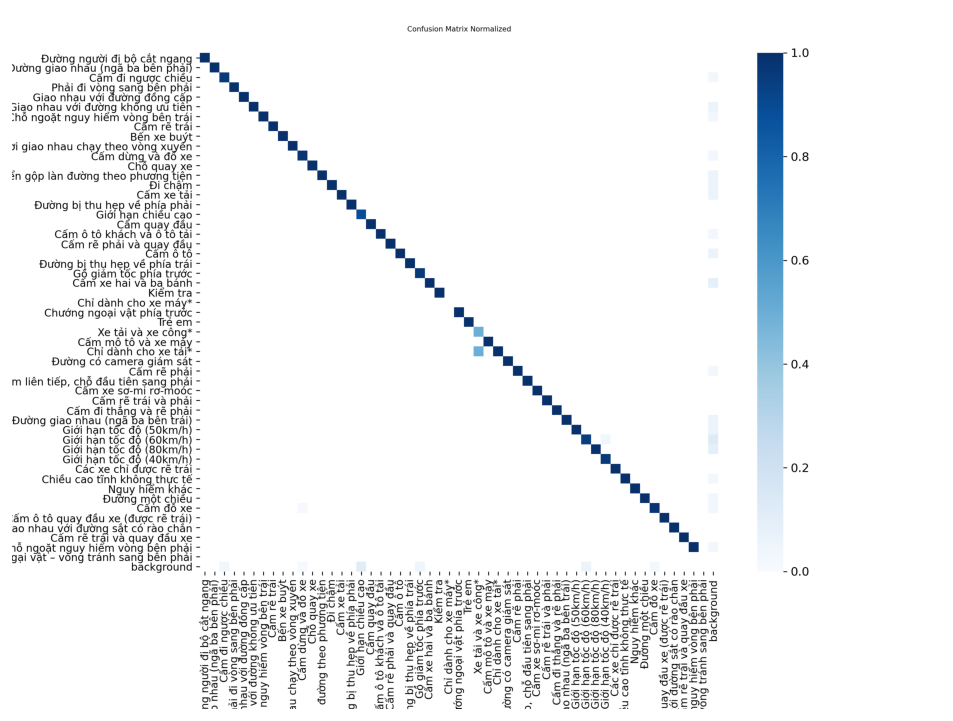

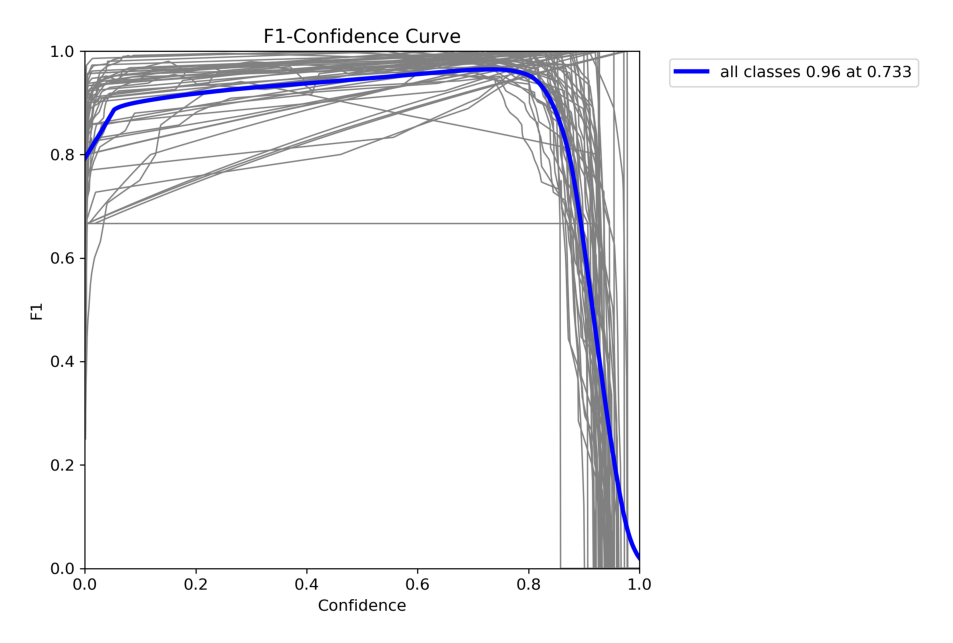

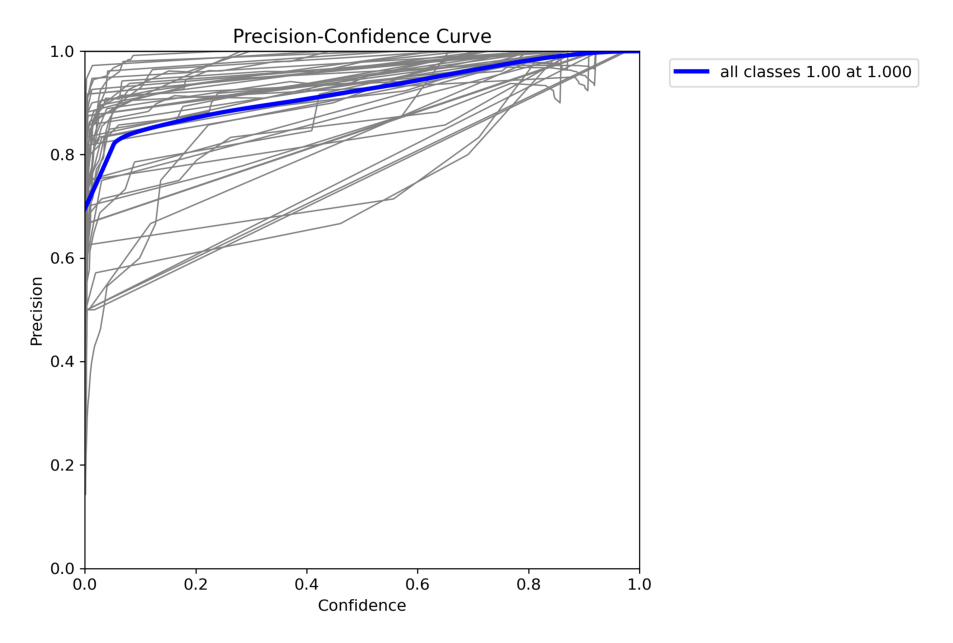

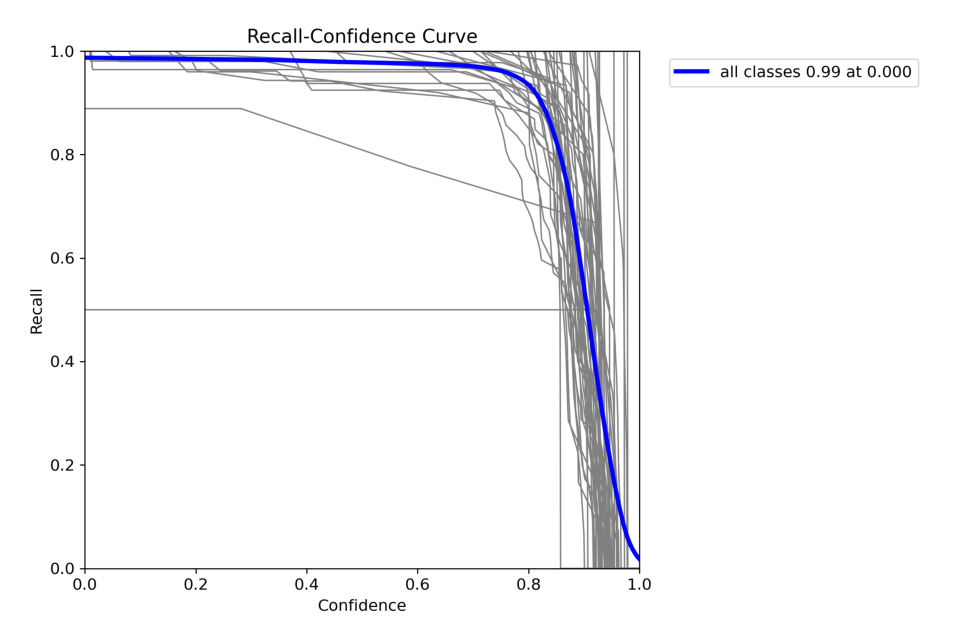

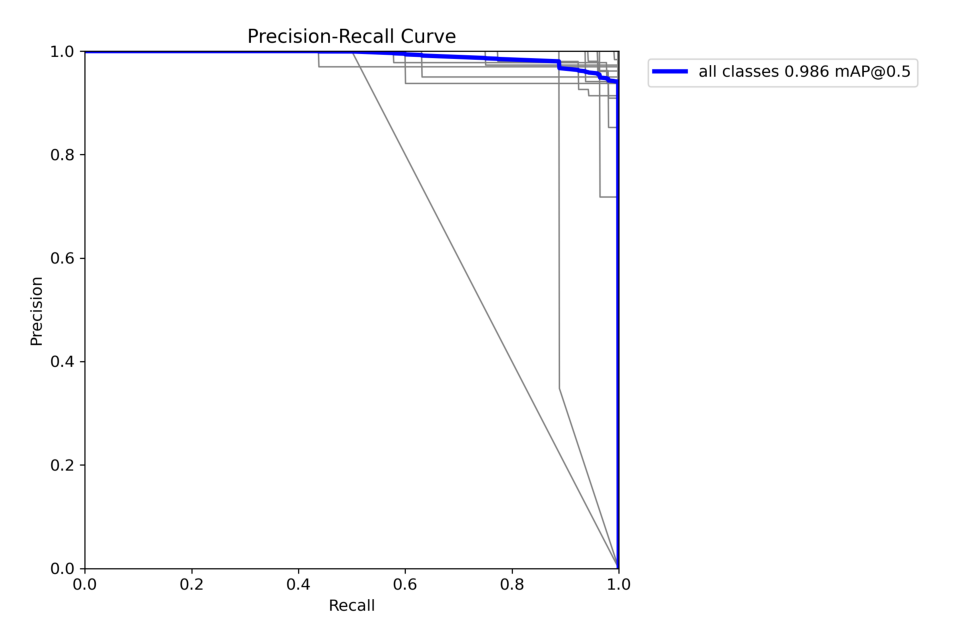

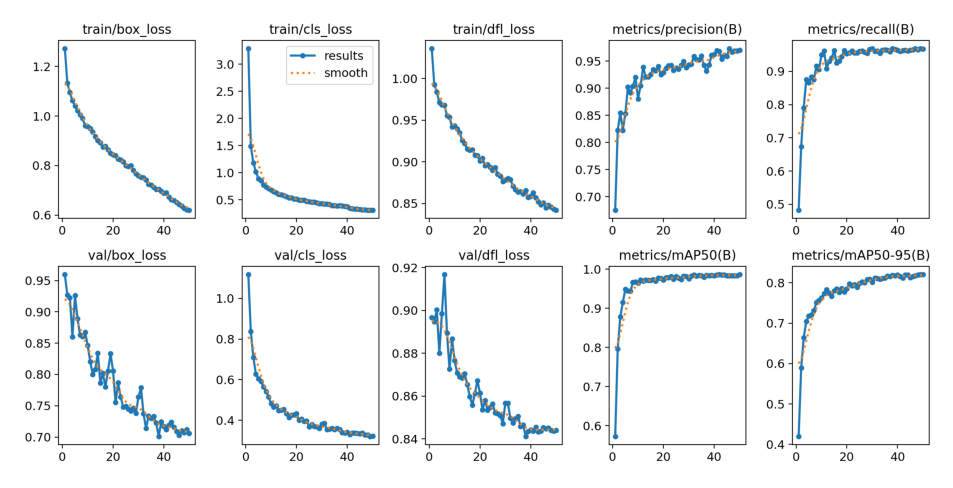

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def display_images(post_training_path, image_files):
    for image_file in image_files:
        image_path = os.path.join(post_training_path, image_file)
        if not os.path.exists(image_path):
            print(f"Tệp {image_path} không tồn tại.")
            continue

        try:
            img = Image.open(image_path)
            plt.figure(figsize=(10, 10), dpi=120)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Không thể mở tệp {image_path}: {e}")

post_training_path = '/content/runs/detect/train2'
image_files = [
    'confusion_matrix_normalized.png',
    'BoxF1_curve.png',
    'BoxP_curve.png',
    'BoxR_curve.png',
    'BoxPR_curve.png',
    'results.png'
]
display_images(post_training_path, image_files)

In [3]:
import pandas as pd
Result_model = pd.read_csv('/content/runs/detect/train2/results.csv')
Result_model.tail(10)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
40,41,7706.99,0.69028,0.34547,0.86305,0.96903,0.96029,0.98505,0.81620,0.71223,0.32885,0.84371,0.000037,0.000037,0.000037
41,42,7893.38,0.67353,0.33845,0.85704,0.96758,0.96321,0.98591,0.81184,0.71889,0.33787,0.84554,0.000034,0.000034,0.000034
42,43,8079.38,0.66238,0.33100,0.85210,0.95384,0.96449,0.98508,0.81963,0.72401,0.33615,0.84337,0.000030,0.000030,0.000030
43,44,8265.48,0.65927,0.32944,0.84859,0.96087,0.96139,0.98540,0.81986,0.71571,0.33433,0.84367,0.000027,0.000027,0.000027
44,45,8453.12,0.65099,0.32137,0.85074,0.95883,0.96451,0.98350,0.81274,0.70913,0.33379,0.84529,0.000023,0.000023,0.000023
45,46,8639.71,0.64257,0.31806,0.84467,0.97320,0.96553,0.98308,0.81544,0.70270,0.33763,0.84478,0.000020,0.000020,0.000020
46,47,8826.04,0.63744,0.31245,0.84790,0.96666,0.96927,0.98348,0.81771,0.71044,0.32820,0.84521,0.000016,0.000016,0.000016
47,48,9012.35,0.62704,0.30931,0.84580,0.96867,0.96497,0.98373,0.82002,0.70713,0.32696,0.84405,0.000012,0.000012,0.000012
48,49,9198.40,0.62179,0.30696,0.84352,0.96890,0.96907,0.98376,0.82016,0.71237,0.32054,0.84377,0.000009,0.000009,0.000009
49,50,9384.88,0.61939,0.30767,0.84198,0.97005,0.96781,0.98622,0.82055,0.70608,0.32176,0.84403,0.000005,0.000005,0.000005


In [4]:
Valid_model = YOLO('/content/runs/detect/train2/weights/best.pt')

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val')

# final results
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,070,124 parameters, 0 gradients, 67.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2796.1±1154.9 MB/s, size: 134.5 KB)


val: Scanning /content/datasets/valid/labels.cache... 321 images, 5 backgrounds, 0 corrupt: 100%|██████████| 321/321 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


                   all        321        873       0.97      0.968      0.986      0.825
Đường người đi bộ cắt ngang         25         25          1      0.967      0.995      0.761
Đường giao nhau (ngã ba bên phải)          2          2      0.948          1      0.995      0.659
    Cấm đi ngược chiều         51         52          1      0.904      0.992      0.762
Phải đi vòng sang bên phải         49         49          1      0.901      0.995      0.751
Giao nhau với đường đồng cấp          3          3      0.951          1      0.995      0.781
Giao nhau với đường không ưu tiên         25         25       0.96          1      0.995      0.817
Chỗ ngoặt nguy hiểm vòng bên trái         16         16          1      0.934      0.991      0.866
           Cấm rẽ trái         35         35          1      0.951      0.995      0.777
           Bến xe buýt         15         15          1      0.972      0.995      0.795
Nơi giao nhau chạy theo vòng xuyến          7          7      